In [138]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import plotly.graph_objs as go

import xgboost as xgb 
from sklearn.metrics import mean_squared_error, mean_squared_error
from plotly.offline import iplot

import warnings
warnings.filterwarnings('ignore')

In [139]:
path = '../dasatet_5/BritishMart.csv'

bm = pd.read_csv(path)
pd.set_option('display.max_colwidth', None)

In [140]:
# Map sesuai perubahan
unit_mapping = {'kg': 'kg', 'l': 'litre', 'unit': 'ounces', 'm': 'meter'}

bm['unit'] = bm['unit'].replace(unit_mapping)

In [141]:
bm_empty = bm[bm.isna().any(axis=1)]

In [142]:
bm_empty

,nama_toko,harga_pound,harga_per_unit,unit,nama,kategori,brand_sendiri,tanggal


In [143]:
bm.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 979866 entries, 0 to 979865
Data columns (total 8 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   nama_toko       979866 non-null  object 
 1   harga_pound     979866 non-null  float64
 2   harga_per_unit  979866 non-null  float64
 3   unit            979866 non-null  object 
 4   nama            979866 non-null  object 
 5   kategori        979866 non-null  object 
 6   brand_sendiri   979866 non-null  bool   
 7   tanggal         979866 non-null  object 
dtypes: bool(1), float64(2), object(5)
memory usage: 53.3+ MB


# Standarisasi 'kategori'

In [144]:
bm[bm['nama'] == 'Alpro Almond Chilled Drink'].head(10)

,nama_toko,harga_pound,harga_per_unit,unit,nama,kategori,brand_sendiri,tanggal
1,BritishMart,2.1,2.1,litre,Alpro Almond Chilled Drink,drinks,False,2021-01-01
16332,BritishMart,2.1,2.1,litre,Alpro Almond Chilled Drink,free-from,False,2021-01-20
36698,BritishMart,2.1,2.1,litre,Alpro Almond Chilled Drink,drinks,False,2021-02-13
60982,BritishMart,2.1,2.1,litre,Alpro Almond Chilled Drink,fresh_food,False,2021-03-13
89688,BritishMart,2.1,2.1,litre,Alpro Almond Chilled Drink,fresh_food,False,2021-04-16
109517,BritishMart,2.1,2.1,litre,Alpro Almond Chilled Drink,fresh_food,False,2021-05-10
125376,BritishMart,2.1,2.1,litre,Alpro Almond Chilled Drink,fresh_food,False,2021-05-28
152528,BritishMart,2.1,2.1,litre,Alpro Almond Chilled Drink,drinks,False,2021-06-29
167763,BritishMart,2.1,2.1,litre,Alpro Almond Chilled Drink,drinks,False,2021-07-17
189559,BritishMart,2.1,2.1,litre,Alpro Almond Chilled Drink,drinks,False,2021-08-12


In [145]:
mode_kategori = bm.groupby('nama')['kategori'].agg(lambda x: x.mode()[0])
bm = pd.merge(bm, mode_kategori, how='left', on='nama', suffixes=('', '_mode'))
bm['kategori'] = bm['kategori_mode']
bm.drop(columns=['kategori_mode'], inplace=True)

In [146]:
bm[bm['nama'] == 'Alpro Almond Chilled Drink'].head(10)

,nama_toko,harga_pound,harga_per_unit,unit,nama,kategori,brand_sendiri,tanggal
1,BritishMart,2.1,2.1,litre,Alpro Almond Chilled Drink,free-from,False,2021-01-01
16332,BritishMart,2.1,2.1,litre,Alpro Almond Chilled Drink,free-from,False,2021-01-20
36698,BritishMart,2.1,2.1,litre,Alpro Almond Chilled Drink,free-from,False,2021-02-13
60982,BritishMart,2.1,2.1,litre,Alpro Almond Chilled Drink,free-from,False,2021-03-13
89688,BritishMart,2.1,2.1,litre,Alpro Almond Chilled Drink,free-from,False,2021-04-16
109517,BritishMart,2.1,2.1,litre,Alpro Almond Chilled Drink,free-from,False,2021-05-10
125376,BritishMart,2.1,2.1,litre,Alpro Almond Chilled Drink,free-from,False,2021-05-28
152528,BritishMart,2.1,2.1,litre,Alpro Almond Chilled Drink,free-from,False,2021-06-29
167763,BritishMart,2.1,2.1,litre,Alpro Almond Chilled Drink,free-from,False,2021-07-17
189559,BritishMart,2.1,2.1,litre,Alpro Almond Chilled Drink,free-from,False,2021-08-12


In [147]:
def recategorize(data):
    if data['brand_sendiri'] == True:
        return 1
    return 0

In [148]:
bm['brand_sendiri'] = bm.apply(recategorize, axis=1)

In [149]:
bm_cleaned = bm.loc[:,['harga_per_unit', 'nama', 'kategori', 'tanggal', 'brand_sendiri']]
bm_cleaned['tanggal'] = pd.to_datetime(bm_cleaned['tanggal'])
bm_cleaned.index = bm_cleaned.pop('tanggal')
bm_cleaned.sort_index(inplace=True)

In [150]:
bm_cleaned

,harga_per_unit,nama,kategori,brand_sendiri
tanggal,,,,
2021-01-01,1.35,Alpro Oat Long Life Drink,drinks,0
2021-01-01,2.10,Alpro Soya Chocolate Chilled Drink,free-from,0
2021-01-01,2.70,Cawston Press Apple & Ginger Juice,drinks,0
2021-01-01,4.23,Dunn's River Nurishment Vanilla Milk,drinks,0
2021-01-01,3.20,Lipton Ice Tea Raspberry,drinks,0
...,...,...,...,...
2024-02-29,4.00,Harry Potter Paper Stationery Pouch,home,0
2024-02-29,5.00,Hinkler Animal Rock Painting Kit,home,0
2024-02-29,24.00,Hp 300 Colour Ink Cartridge Bb,home,0


# EDA

In [151]:
bm['tanggal'] = pd.to_datetime(bm['tanggal'])
monthly_sales = bm.resample('ME', on='tanggal')['harga_per_unit'].mean().reset_index()

monthly_sales_sc = go.Scatter(x=monthly_sales['tanggal'], y=monthly_sales['harga_per_unit'])
layout = go.Layout(title='Monthly price', xaxis=dict(title='Date'), yaxis=dict(title='Price'))
fig = go.Figure(data=[monthly_sales_sc], layout=layout)
iplot(fig)

In [152]:
bm.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 979866 entries, 0 to 979865
Data columns (total 8 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   nama_toko       979866 non-null  object        
 1   harga_pound     979866 non-null  float64       
 2   harga_per_unit  979866 non-null  float64       
 3   unit            979866 non-null  object        
 4   nama            979866 non-null  object        
 5   kategori        979866 non-null  object        
 6   brand_sendiri   979866 non-null  int64         
 7   tanggal         979866 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 59.8+ MB


In [153]:
daily_price_per_unit = bm.groupby('tanggal', as_index=False)['harga_per_unit'].sum()
kategori_daily_price = bm.groupby(['kategori', 'tanggal'], as_index=False)['harga_per_unit'].sum()
unit_daily_price = bm.groupby(['unit', 'tanggal'], as_index=False)['harga_per_unit'].sum()

# daily_price_pu = go.Scatter(x=daily_price_per_unit[daily_price_per_unit['tanggal'] > '2022'], y=daily_price_per_unit['harga_per_unit'])
# layout = go.Layout(title='Daily price per unit', xaxis=dict(title='Date'), yaxis=dict(title='Price'))
# fig = go.Figure(data=[daily_price_pu], layout=layout)
# iplot(fig)

filtered_date = daily_price_per_unit[(daily_price_per_unit['tanggal'] >= '2021') & (daily_price_per_unit['tanggal'] <= '2023')]
daily_price_pu = go.Scatter(x=filtered_date['tanggal'], y=filtered_date['harga_per_unit'])
layout = go.Layout(title='Daily Price per Unit (2021-2023)', xaxis=dict(title='Date'), yaxis=dict(title='Price'))
fig = go.Figure(data=[daily_price_pu], layout=layout)
iplot(fig)


In [154]:
daily_price_per_customer = bm.groupby('tanggal', as_index=False)['harga_pound'].sum()
kategori_daily_price_per_customer = bm.groupby(['kategori', 'tanggal'], as_index=False)['harga_pound'].sum()
unit_daily_price_per_customer = bm.groupby(['unit', 'tanggal'], as_index=False)['harga_pound'].sum()

daily_price_pc = go.Scatter(x=daily_price_per_customer['tanggal'], y=daily_price_per_customer['harga_pound'])
layout = go.Layout(title='Daily price per customer', xaxis=dict(title='Date'), yaxis=dict(title='Price'))
fig = go.Figure(data=[daily_price_pc], layout=layout)
iplot(fig)

In [155]:
kategori_daily_sales_sc = []
for kategori in kategori_daily_price['kategori'].unique():
    current_store_daily_sales = kategori_daily_price[(kategori_daily_price['kategori'] == kategori)]
    kategori_daily_sales_sc.append(go.Scatter(x=current_store_daily_sales['tanggal'], y=current_store_daily_sales['harga_per_unit'], name=('Kategori %s' % kategori)))

layout = go.Layout(title='Kategori daily price', xaxis=dict(title='Date'), yaxis=dict(title='Price'))
fig = go.Figure(data=kategori_daily_sales_sc, layout=layout)
iplot(fig)

In [156]:
unit_daily_sales_sc = []
for unit in unit_daily_price['unit'].unique():
    current_unit_daily_price = unit_daily_price[(unit_daily_price['unit'] == unit)]
    unit_daily_sales_sc.append(go.Scatter(x=current_unit_daily_price['tanggal'], y=current_unit_daily_price['harga_per_unit'], name=('Unit %s' % unit)))

layout = go.Layout(title='Unit daily price', xaxis=dict(title='Date'), yaxis=dict(title='Price'))
fig = go.Figure(data=unit_daily_sales_sc, layout=layout)
iplot(fig)

In [157]:
bm_cleaned

,harga_per_unit,nama,kategori,brand_sendiri
tanggal,,,,
2021-01-01,1.35,Alpro Oat Long Life Drink,drinks,0
2021-01-01,2.10,Alpro Soya Chocolate Chilled Drink,free-from,0
2021-01-01,2.70,Cawston Press Apple & Ginger Juice,drinks,0
2021-01-01,4.23,Dunn's River Nurishment Vanilla Milk,drinks,0
2021-01-01,3.20,Lipton Ice Tea Raspberry,drinks,0
...,...,...,...,...
2024-02-29,4.00,Harry Potter Paper Stationery Pouch,home,0
2024-02-29,5.00,Hinkler Animal Rock Painting Kit,home,0
2024-02-29,24.00,Hp 300 Colour Ink Cartridge Bb,home,0


In [158]:
kategori_price = bm_cleaned.groupby('kategori').resample('ME')['harga_per_unit'].mean().reset_index()

fig = go.Figure()

for kategori in kategori_price['kategori'].unique():
    kategori_data = kategori_price[kategori_price['kategori'] == kategori]
    fig.add_trace(go.Scatter(
        x=kategori_data['tanggal'],
        y=kategori_data['harga_per_unit'],
        mode='lines',
        name=kategori
    ))

fig.update_layout(
    title='Increase in Harga Per Unit by Category',
    xaxis_title='Date',
    yaxis_title='Harga Per Unit',
    legend_title='Category'
)

iplot(fig)

In [159]:
bm_cleaned

,harga_per_unit,nama,kategori,brand_sendiri
tanggal,,,,
2021-01-01,1.35,Alpro Oat Long Life Drink,drinks,0
2021-01-01,2.10,Alpro Soya Chocolate Chilled Drink,free-from,0
2021-01-01,2.70,Cawston Press Apple & Ginger Juice,drinks,0
2021-01-01,4.23,Dunn's River Nurishment Vanilla Milk,drinks,0
2021-01-01,3.20,Lipton Ice Tea Raspberry,drinks,0
...,...,...,...,...
2024-02-29,4.00,Harry Potter Paper Stationery Pouch,home,0
2024-02-29,5.00,Hinkler Animal Rock Painting Kit,home,0
2024-02-29,24.00,Hp 300 Colour Ink Cartridge Bb,home,0


# Ambil Contoh Health Products (diubah nanti di akhir)

In [160]:
hp_data = bm_cleaned[bm_cleaned['kategori'] == 'health_products']
harga_per_unit_daily = hp_data[['harga_per_unit']]
hp_avg = harga_per_unit_daily.groupby(harga_per_unit_daily.index).mean()

In [161]:
hp_avg

,harga_per_unit
tanggal,
2021-01-01,3.600000
2021-01-02,7.000000
2021-01-04,17.045455
2021-01-06,2.400000
2021-01-07,61.028124
...,...
2024-02-25,39.062632
2024-02-26,41.569630
2024-02-27,34.018250


# Feature Creation

In [162]:
def create_features(data):
    data['dayofweek']= data.index.dayofweek
    data['quarter']= data.index.quarter
    data['month']= data.index.month
    data['year']= data.index.year
    data['dayofyear']= data.index.dayofyear
    return data

In [163]:
hp_avg = create_features(hp_avg)

# Moving Average and Shift Function

In [164]:
hp_avg['moving_avg_per_triduum'] = hp_avg['harga_per_unit'].rolling(window=3).mean()

In [165]:
# Shift for n+1 - n-1
hp_avg['prev_harga'] = hp_avg['harga_per_unit'].shift(1)
hp_avg['next_harga'] = hp_avg['harga_per_unit'].shift(-1)

hp_avg['increase'] = 0  # Initialize with 0
mask = hp_avg.index != hp_avg.index[0]
mask &= hp_avg.index != hp_avg.index[-1]
hp_avg.loc[mask, 'increase'] = (hp_avg['harga_per_unit'] - hp_avg['prev_harga']) + (hp_avg['next_harga'] - hp_avg['harga_per_unit'])

hp_avg['increase'].iloc[0] = 0
hp_avg['increase'].iloc[-1] = 0

hp_avg = hp_avg.drop(columns=['prev_harga', 'next_harga'])

In [166]:
hp_avg

,harga_per_unit,dayofweek,quarter,month,year,dayofyear,moving_avg_per_triduum,increase
tanggal,,,,,,,,
2021-01-01,3.600000,4,1,1,2021,1,NaN,0.000000
2021-01-02,7.000000,5,1,1,2021,2,NaN,13.445455
2021-01-04,17.045455,0,1,1,2021,4,9.215152,-4.600000
2021-01-06,2.400000,2,1,1,2021,6,8.815152,43.982670
2021-01-07,61.028124,3,1,1,2021,7,26.824526,146.522376
...,...,...,...,...,...,...,...,...
2024-02-25,39.062632,6,1,2,2024,56,119.652765,-130.726616
2024-02-26,41.569630,0,1,2,2024,57,84.309502,-5.044382
2024-02-27,34.018250,1,1,2,2024,58,38.216837,-33.525219


# Split Train (80%) Test (20%)

In [167]:
train = hp_avg.loc[hp_avg.index < '2023-07-31']
test = hp_avg.loc[hp_avg.index >= '2023-07-31'] 

print(f'Number of days in train data: {len(train.index)}')
print(f'Number of days in test data: {len(test.index)}')

Number of days in train data: 852
Number of days in test data: 213


In [168]:
trace_train = go.Scatter(x=train.index, y=train['harga_per_unit'], mode='lines', name='Train')
trace_test = go.Scatter(x=test.index, y=test['harga_per_unit'], mode='lines', name='Test')

layout = go.Layout(title='Train and Test Data', xaxis=dict(title='Date'), yaxis=dict(title='Harga Per Unit'))
fig = go.Figure(data=[trace_train, trace_test], layout=layout)

fig.show()

In [169]:
train = create_features(train)
test = create_features(test)

FEATURES = ['dayofweek', 'quarter', 'month', 'year', 'dayofyear', 'increase', 'moving_avg_per_triduum']
TARGET = 'harga_per_unit'

In [170]:
X_train = train[FEATURES]
y_train = train[TARGET]

X_test = test[FEATURES]
y_test = test[TARGET]

# Modelling

In [171]:
reg = xgb.XGBRegressor(n_estimators=100000, 
                       early_stopping_rounds=10000,
                       learning_rate=0.001,
                       reg_alpha=0.1,
                       reg_lambda=0.1,
                       max_depth=5,
                       min_child_weight=1,
                       subsample=0.8)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        verbose=1000)

[0]	validation_0-rmse:51.38928	validation_1-rmse:50.95787


[1000]	validation_0-rmse:28.54024	validation_1-rmse:34.37250
[2000]	validation_0-rmse:21.69794	validation_1-rmse:30.84766
[3000]	validation_0-rmse:18.79555	validation_1-rmse:30.12145
[4000]	validation_0-rmse:16.98398	validation_1-rmse:30.01516
[5000]	validation_0-rmse:15.58412	validation_1-rmse:30.05969
[6000]	validation_0-rmse:14.29993	validation_1-rmse:30.06778
[7000]	validation_0-rmse:13.16293	validation_1-rmse:30.05489
[8000]	validation_0-rmse:12.15960	validation_1-rmse:30.08039
[9000]	validation_0-rmse:11.25396	validation_1-rmse:30.10321
[10000]	validation_0-rmse:10.44168	validation_1-rmse:30.13018
[11000]	validation_0-rmse:9.72131	validation_1-rmse:30.15673
[12000]	validation_0-rmse:9.08145	validation_1-rmse:30.17909
[13000]	validation_0-rmse:8.47965	validation_1-rmse:30.21404
[13727]	validation_0-rmse:8.07637	validation_1-rmse:30.22399


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=10000,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.001, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=1, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100000, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

# Feature Importances

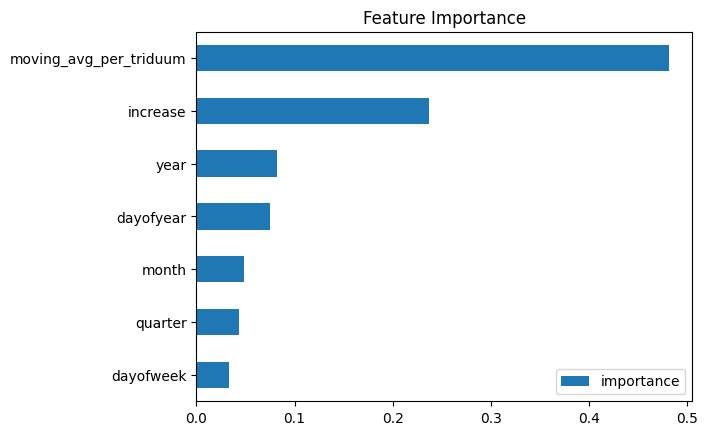

In [172]:
fi = pd.DataFrame(data=reg.feature_importances_,
                  index=reg.feature_names_in_,
                  columns=['importance'])
fi.sort_values('importance').plot(kind='barh', title='Feature Importance')
plt.show()

# Forecast

In [173]:
test['prediction'] = reg.predict(X_test)
hp_avg = hp_avg.merge(test[['prediction']], how='left', left_index=True, right_index=True)

In [174]:
# Week test
# filtered_data = hp_avg.loc[(hp_avg.index > '2024-02-01') & (hp_avg.index <= '2024-02-29')] 

# filtered_data = hp_avg.loc[(hp_avg.index > '2023-07-30') & (hp_avg.index <= '2024-02-29')]
filtered_data = hp_avg.loc[(hp_avg.index > '2024-01-31') & (hp_avg.index <= '2024-02-29')]

In [175]:
trace1 = go.Scatter(x=filtered_data.index, y=filtered_data['harga_per_unit'], mode='lines', opacity=0.5, name='Truth Data')
trace2 = go.Scatter(x=filtered_data.index, y=filtered_data['prediction'], mode='lines', opacity=1, name='Predictions')
layout = go.Layout(title='Entire Test Data', xaxis=dict(title='Date'), yaxis=dict(title='Harga Per Unit'), legend=dict(x=0, y=1))

fig = go.Figure(data=[trace1, trace2], layout=layout)
fig.show()

In [176]:
hp_avg.tail(10)

,harga_per_unit,dayofweek,quarter,month,year,dayofyear,moving_avg_per_triduum,increase,prediction
tanggal,,,,,,,,,
2024-02-20,79.395759,1,1,2,2024,51,114.631580,-59.587377,117.661827
2024-02-21,61.032863,2,1,2,2024,52,87.016287,-38.340825,73.693275
2024-02-22,41.054933,3,1,2,2024,53,60.494518,86.566556,77.417427
2024-02-23,147.599419,4,1,2,2024,54,83.229072,131.241312,113.523117
2024-02-24,172.296246,5,1,2,2024,55,120.316866,-108.536787,136.409851
2024-02-25,39.062632,6,1,2,2024,56,119.652765,-130.726616,105.077927
2024-02-26,41.569630,0,1,2,2024,57,84.309502,-5.044382,76.630928
2024-02-27,34.018250,1,1,2,2024,58,38.216837,-33.525219,32.297123
2024-02-28,8.044410,2,1,2,2024,59,27.877430,-24.073930,24.874002


# Calculate Error

In [177]:
score = np.sqrt(mean_squared_error(test['harga_per_unit'], test['prediction']))

In [178]:
test['error'] = np.abs(test[TARGET] - test['prediction'])
test['date'] = test.index.date

In [179]:
# Worst predicted
test.groupby(['date'])['error'].mean().sort_values(ascending=False).head(5)

date
2023-09-03    115.415053
2023-12-03    108.844338
2023-11-11    100.171357
2023-10-31     89.712541
2023-08-25     84.208089
Name: error, dtype: float64

In [180]:
# Best predicted
test.groupby(['date'])['error'].mean().sort_values(ascending=True).head(5)

date
2023-11-03    0.155504
2023-08-15    0.166746
2023-10-01    0.192398
2024-02-10    0.427829
2023-08-13    0.479583
Name: error, dtype: float64

In [181]:
def calculate_mape(actual, predicted):
    return np.mean(np.abs((actual - predicted) / actual)) * 100

actual_values = hp_avg['harga_per_unit']
predicted_values = hp_avg['prediction']
mape = calculate_mape(actual_values, predicted_values)
MSE = test['error'].mean()

results = pd.DataFrame({
    'Metric': ['MSE', 'MAPE'],
    'Value': [MSE, f"{mape.round(2)}%"]
})

In [182]:
print("======XGBoost Model Result======")
print(results)

======XGBoost Model Result======
  Metric      Value
0    MSE  20.274789
1   MAPE     58.88%


---
# Coba Foodcup 

In [183]:
bm_cleaned['kategori'].unique()

array(['drinks', 'free-from', 'food_cupboard', 'fresh_food', 'home',
       'frozen', 'health_products', 'bakery', 'baby_products',
       'household', 'pets'], dtype=object)

In [184]:
fc_data = bm_cleaned[bm_cleaned['kategori'] == 'food_cupboard']
harga_per_unit_daily = fc_data[['harga_per_unit']]
fc_avg = harga_per_unit_daily.groupby(harga_per_unit_daily.index).mean()

In [185]:
fc_avg = create_features(fc_avg)

In [186]:
fc_avg['moving_avg_per_triduum'] = fc_avg['harga_per_unit'].rolling(window=3).mean()
fc_avg['moving_avg_per_triduum'] = fc_avg['moving_avg_per_triduum'].fillna(0)

In [187]:
# Shift for n+1 - n-1
fc_avg['prev_harga'] = fc_avg['harga_per_unit'].shift(1)
fc_avg['next_harga'] = fc_avg['harga_per_unit'].shift(-1)

fc_avg['increase'] = 0  # Initialize with 0
mask = fc_avg.index != fc_avg.index[0]
mask &= fc_avg.index != fc_avg.index[-1]
fc_avg.loc[mask, 'increase'] = (fc_avg['harga_per_unit'] - fc_avg['prev_harga']) + (fc_avg['next_harga'] - fc_avg['harga_per_unit'])

fc_avg['increase'].iloc[0] = 0
fc_avg['increase'].iloc[-1] = 0

fc_avg = fc_avg.drop(columns=['prev_harga', 'next_harga'])

In [188]:
fc_avg

,harga_per_unit,dayofweek,quarter,month,year,dayofyear,moving_avg_per_triduum,increase
tanggal,,,,,,,,
2021-01-01,1.928333,4,1,1,2021,1,0.000000,0.000000
2021-01-02,18.400000,5,1,1,2021,2,0.000000,12.182213
2021-01-04,14.110546,0,1,1,2021,4,11.479626,-14.360000
2021-01-05,4.040000,1,1,1,2021,5,12.183515,-11.010546
2021-01-06,3.100000,2,1,1,2021,6,7.083515,11.710000
...,...,...,...,...,...,...,...,...
2024-02-23,7.477534,4,1,2,2024,54,25.894316,-2.086244
2024-02-24,9.595300,5,1,2,2024,55,9.584793,5.259530
2024-02-25,12.737065,6,1,2,2024,56,9.936633,29.143021


In [189]:
train_fc = fc_avg.loc[fc_avg.index < '2023-07-29']
test_fc = fc_avg.loc[fc_avg.index >= '2023-07-29'] 

print(f'Number of days in train data: {len(train_fc.index)}')
print(f'Number of days in test data: {len(test_fc.index)}')

Number of days in train data: 770
Number of days in test data: 192


In [190]:

trace_train = go.Scatter(x=train_fc.index, y=train_fc['harga_per_unit'], mode='lines', name='Train')
trace_test = go.Scatter(x=test_fc.index, y=test_fc['harga_per_unit'], mode='lines', name='Test')

layout = go.Layout(title='Train and Test Data', xaxis=dict(title='Date'), yaxis=dict(title='Harga Per Unit'))
fig = go.Figure(data=[trace_train, trace_test], layout=layout)

fig.show()

In [191]:
train_fc = create_features(train_fc)
test = create_features(test_fc)

FEATURES = ['dayofweek', 'quarter', 'month', 'year', 'dayofyear', 'increase', 'moving_avg_per_triduum']
TARGET = 'harga_per_unit'

In [196]:
X_train_fc = train_fc[FEATURES]
y_train_fc = train_fc[TARGET]

X_test_fc = test_fc[FEATURES]
y_test_fc = test_fc[TARGET]

In [197]:
reg = xgb.XGBRegressor(n_estimators=100000, 
                       early_stopping_rounds=10000,
                       learning_rate=0.001,
                       reg_alpha=0.1,
                       reg_lambda=0.1,
                       max_depth=5,
                       min_child_weight=1,
                       subsample=0.8)
reg.fit(X_train_fc, y_train_fc,
        eval_set=[(X_train_fc, y_train_fc), (X_test_fc, y_test_fc)],
        verbose=1000)

[0]	validation_0-rmse:11.78473	validation_1-rmse:11.88741


[1000]	validation_0-rmse:7.23816	validation_1-rmse:8.27698
[2000]	validation_0-rmse:5.45404	validation_1-rmse:7.47215
[3000]	validation_0-rmse:4.55948	validation_1-rmse:7.34304
[4000]	validation_0-rmse:3.99013	validation_1-rmse:7.35114
[5000]	validation_0-rmse:3.54690	validation_1-rmse:7.38732
[6000]	validation_0-rmse:3.19247	validation_1-rmse:7.42325
[7000]	validation_0-rmse:2.89034	validation_1-rmse:7.45743
[8000]	validation_0-rmse:2.63041	validation_1-rmse:7.48605
[9000]	validation_0-rmse:2.40676	validation_1-rmse:7.51400
[10000]	validation_0-rmse:2.21486	validation_1-rmse:7.54053
[11000]	validation_0-rmse:2.04724	validation_1-rmse:7.56009
[12000]	validation_0-rmse:1.89968	validation_1-rmse:7.58076
[13000]	validation_0-rmse:1.76421	validation_1-rmse:7.60070
[13299]	validation_0-rmse:1.72656	validation_1-rmse:7.60558


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=10000,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.001, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=1, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100000, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [203]:
test['prediction'] = reg.predict(X_test_fc)
fc_avg = fc_avg.merge(test[['prediction']], how='left', left_index=True, right_index=True)

In [204]:
filtered_data_fc = fc_avg.loc[(fc_avg.index > '2023-07-29') & (fc_avg.index <= '2024-02-27')]

In [205]:
trace1 = go.Scatter(x=filtered_data_fc.index, y=filtered_data_fc['harga_per_unit'], mode='lines', opacity=0.5, name='Truth Data')
trace2 = go.Scatter(x=filtered_data_fc.index, y=filtered_data_fc['prediction'], mode='lines', opacity=1, name='Predictions')
layout = go.Layout(title='Entire Test Data', xaxis=dict(title='Date'), yaxis=dict(title='Harga Per Unit'), legend=dict(x=0, y=1))

fig = go.Figure(data=[trace1, trace2], layout=layout)
fig.show()

In [207]:
score = np.sqrt(mean_squared_error(test_fc['harga_per_unit'], test_fc['prediction']))
test_fc['error'] = np.abs(test_fc[TARGET] - test_fc['prediction'])
test_fc['date'] = test_fc.index.date

In [208]:
# Worst predicted
test_fc.groupby(['date'])['error'].mean().sort_values(ascending=False).head(5)

date
2024-01-31    42.950927
2024-01-30    34.262898
2023-12-01    33.798242
2023-12-21    21.739579
2024-01-29    20.774374
Name: error, dtype: float64

In [209]:
# Best predicted
test_fc.groupby(['date'])['error'].mean().sort_values(ascending=True).head(5)

date
2024-02-02    0.020550
2024-02-25    0.026909
2023-10-26    0.029880
2023-11-12    0.047397
2023-08-12    0.055311
Name: error, dtype: float64

In [213]:
def calculate_mape(actual, predicted):
    return np.mean(np.abs((actual - predicted) / actual)) * 100

actual_values = fc_avg['harga_per_unit']
predicted_values = fc_avg['prediction']
mape = calculate_mape(actual_values, predicted_values)
MSE = test_fc['error'].mean()

results_fc = pd.DataFrame({
    'Metric': ['MSE', 'MAPE'],
    'Value': [MSE, f"{mape.round(2)}%"]
})

In [214]:
print("======XGBoost Model Result======")
print(results_fc)

======XGBoost Model Result======
  Metric    Value
0    MSE  4.01598
1   MAPE   28.62%
